This Jupyter notebook shows performance of the sharing capability for supply driven facilities. Sources and reactors are deployed to support the deployment of reactors.

# Case 8

Flow: Source -(sourceout)-> Reactor -(reactorout)-> Sink

The facilities 'sink' are supply driven deployed. Two prototypes of sink facilities are deployed with different capacities using the 'sharing capability'.

The next cell produces .xml input file of Cyclus, its respective .sqlite output, and post processing data of that output file used in the following cells.

In [4]:
import json
import re
import subprocess
import os
import sqlite3 as lite
import copy
import glob
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import d3ploy.tester as tester
import d3ploy.plotter as plotter
import collections

# Delete previously generated files
direc = os.listdir('./')
hit_list = glob.glob('*.sqlite') + glob.glob('*.xml') + glob.glob('*.png') + glob.glob('*.csv') + glob.glob('*.txt')
for file in hit_list:
    os.remove(file)

ENV = dict(os.environ)
ENV['PYTHONPATH'] = ".:" + ENV.get('PYTHONPATH', '')

calc_methods = ["ma", "arma", "arch", "poly", "exp_smoothing", "holt_winters", "fft"]

control = """
<control>
    <duration>20</duration>
    <startmonth>1</startmonth>
    <startyear>2000</startyear>
</control>"""

archetypes = """
<archetypes>
        <spec>
            <lib>cycamore</lib>
            <name>Source</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Reactor</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Sink</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullRegion</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullInst</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>DeployInst</name>
        </spec>
        <spec>
            <lib>d3ploy.demand_driven_deployment_inst</lib>
            <name>DemandDrivenDeploymentInst</name>
        </spec>
        <spec>
            <lib>d3ploy.supply_driven_deployment_inst</lib>
            <name>SupplyDrivenDeploymentInst</name>
        </spec>
    </archetypes>
"""

source = """
<facility>
    <name>source</name>
    <config>
        <Source>
            <outcommod>sourceout</outcommod>
            <outrecipe>sourceoutrecipe</outrecipe>
            <throughput>1E6</throughput>
        </Source>
    </config>
</facility>
"""

reactor = """
<facility>
    <name>reactor</name>
    <config>
      <Reactor>
        <fuel_inrecipes>
            <val>sourceoutrecipe</val>
        </fuel_inrecipes>
        <fuel_outrecipes>
            <val>reactoroutrecipe</val>
        </fuel_outrecipes>
        <fuel_incommods>
            <val>sourceout</val>
        </fuel_incommods>
        <fuel_outcommods>
            <val>reactorout</val>
        </fuel_outcommods>
        <cycle_time>5</cycle_time>
        <refuel_time>0</refuel_time>
        <assem_size>1000</assem_size>
        <n_assem_core>3</n_assem_core>
        <n_assem_batch>1</n_assem_batch>
        <power_cap>1000</power_cap>
      </Reactor>
    </config>
</facility>
"""

sink1 = """
<facility>
        <name>sink1</name>
        <config>
            <Sink>
                <in_commods>
                    <val>reactorout</val>
                </in_commods>
                <max_inv_size>200</max_inv_size>
            </Sink>
        </config>
    </facility>
"""

sink2 = """
<facility>
        <name>sink2</name>
        <config>
            <Sink>
                <in_commods>
                    <val>reactorout</val>
                </in_commods>
                <max_inv_size>100</max_inv_size>
            </Sink>
        </config>
    </facility>
"""

region = {}
for calc_method in calc_methods:
    region[calc_method] = """
    <region>
        <config>
            <NullRegion>
            </NullRegion>
        </config>

        <institution>
            <config>
                <NullInst/>
            </config>
            <initialfacilitylist>
            <entry>
              <number>1</number>
              <prototype>source</prototype>
            </entry>
            <entry>
              <number>1</number>
              <prototype>reactor</prototype>
            </entry>
            </initialfacilitylist>
            <name>sink_source_facilities</name>
        </institution>
          
        <institution>
        <config>
            <SupplyDrivenDeploymentInst>
                <calc_method>%s</calc_method>
                <facility_commod>
                    <item>
                        <facility>sink1</facility>
                        <commod>reactorout</commod>
                    </item>
                    <item>
                        <facility>sink2</facility>
                        <commod>reactorout</commod>
                    </item>
                </facility_commod>
                <facility_capacity>
                    <item>
                        <facility>sink1</facility>
                        <capacity>200</capacity>
                    </item>
                    <item>
                        <facility>sink2</facility>
                        <capacity>100</capacity>
                    </item>
                </facility_capacity>
                <facility_sharing>
                    <item>
                        <facility>sink1</facility>
                        <percentage>60</percentage>
                    </item>
                    <item>
                        <facility>sink2</facility>
                        <percentage>40</percentage>
                    </item>                    
                </facility_sharing>
            </SupplyDrivenDeploymentInst>
        </config>
        <name>supply_inst</name>
        </institution>
            
        <name>SingleRegion</name>
    </region>
    """%(calc_method)

recipe = """
<recipe>
   <name>sourceoutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>U235</id> <comp>0.711</comp> </nuclide>
   <nuclide> <id>U238</id> <comp>99.289</comp> </nuclide>
</recipe>
 
<recipe>
   <name>reactoroutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>Kr85</id> <comp>50</comp> </nuclide>
   <nuclide> <id>Cs137</id> <comp>50</comp> </nuclide>
</recipe>
 """

for calc_method in calc_methods:
    input_file = 'case8_'+ calc_method +'.xml'
    output_file = 'case8_'+ calc_method +'.sqlite'
    name = 'case8_'+ calc_method +'_reactorout'

    with open(input_file, 'w') as f:
        f.write('<simulation>\n')
        f.write(control + archetypes)
        f.write(source + reactor + sink1 + sink2)
        f.write(region[calc_method])
        f.write(recipe)
        f.write('</simulation>')

    s = subprocess.check_output(['cyclus', '-o', output_file, input_file],
                            universal_newlines=True, env=ENV)


In [9]:
metric_dict = {}
for calc_method in calc_methods:
    input_file = 'case8_'+ calc_method +'.xml'
    output_file = 'case8_'+ calc_method +'.sqlite'
    name = 'case8_'+ calc_method +'_reactorout'

    agent_entry_dict = {}
    commod_dict = { 'reactorout': ['sink1', 'sink2']}
    for commod, facility in commod_dict.items():
        agent_entry_dict[commod] = tester.get_agent_dict(output_file, facility)
    
    print(agent_entry_dict['reactorout'])
   
    all_dict_spentfuel = {} 
    all_dict_spentfuel = tester.supply_demand_dict_nondriving(output_file, 'reactorout', False)
    plotter.plot_demand_supply_agent(all_dict_spentfuel, agent_entry_dict['reactorout'],
                                     'reactorout', name, False, True, False, 5)

{'sink1': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 6, 12: 6, 13: 6, 14: 6, 15: 6, 16: 9, 17: 9, 18: 9, 19: 9, 20: 9}, 'sink2': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 4, 7: 4, 8: 4, 9: 4, 10: 4, 11: 8, 12: 8, 13: 8, 14: 8, 15: 8, 16: 12, 17: 12, 18: 12, 19: 12, 20: 12}}


/home/roberto/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


{'sink1': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 4, 19: 4, 20: 4}, 'sink2': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 4, 19: 4, 20: 4}}
{'sink1': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 2, 7: 3, 8: 3, 9: 3, 10: 3, 11: 4, 12: 4, 13: 4, 14: 4, 15: 4, 16: 5, 17: 6, 18: 6, 19: 6, 20: 6}, 'sink2': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 2, 7: 3, 8: 3, 9: 3, 10: 3, 11: 4, 12: 4, 13: 4, 14: 4, 15: 4, 16: 6, 17: 7, 18: 7, 19: 7, 20: 7}}
{'sink1': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5}, 'sink2': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5}}
{'sink1': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15:

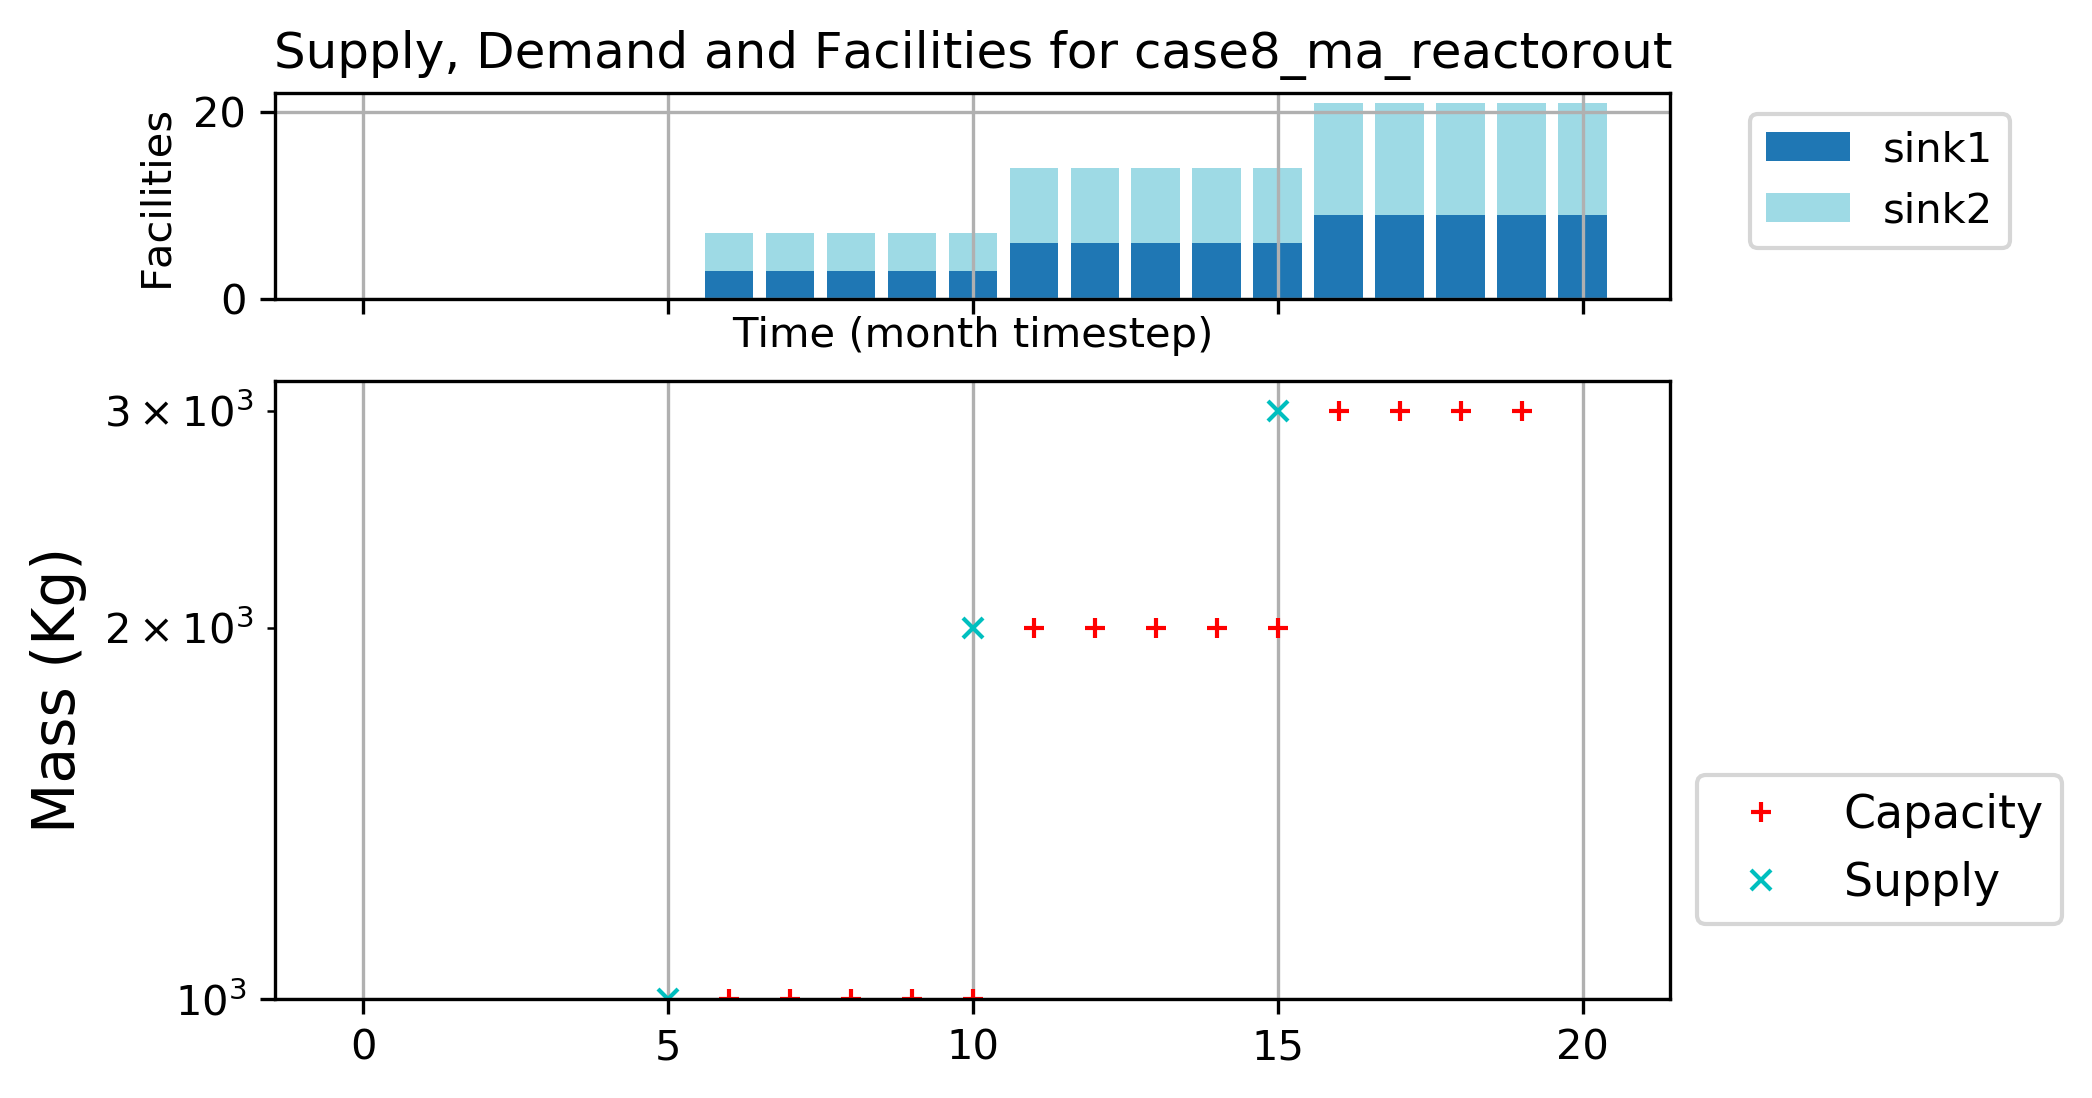

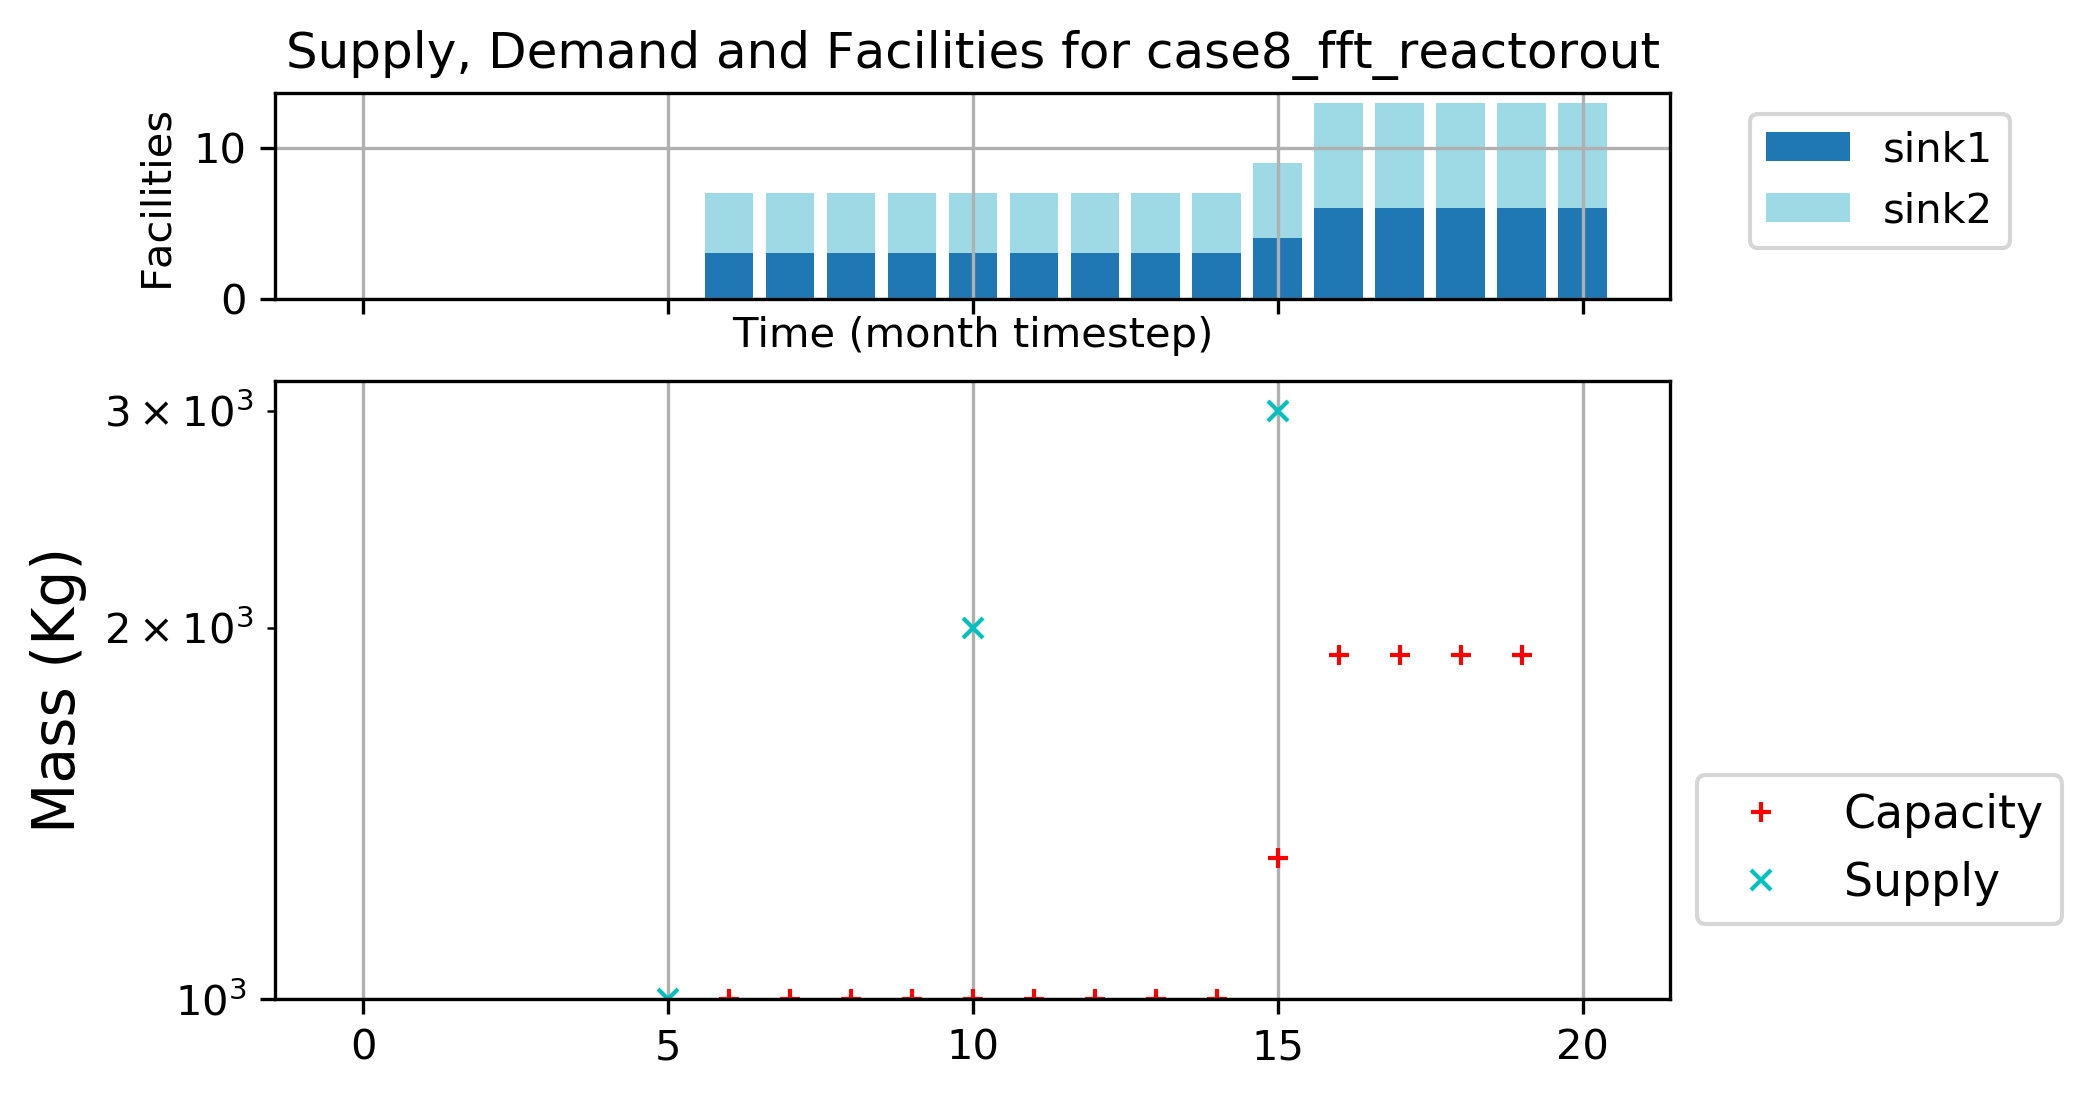

In [11]:
from IPython.display import Image
from IPython.display import display

I1 = Image(filename='case8_ma_reactorout.png')
I2 = Image(filename='case8_fft_reactorout.png')

display(I1, I2)
